## Data

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

from gensim.corpora import Dictionary
from gensim.matutils import corpus2csc, corpus2dense
from gensim.sklearn_api import TfIdfTransformer

from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing

import os
import time

from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax.nn import softmax

In [22]:
data = pd.read_csv("/Users/jonny/Desktop/Dataset/Amazon Reviews/train_40k.csv").loc[:, ["Title", "Cat1", "Cat2"]]
data = data[~data.Title.isna()]
small_data = data.groupby('Cat2', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 200), random_state = 42)).reset_index(drop = True)

small_data.head()

print("Number of primary cats: ", len(small_data.Cat1.value_counts()))
print("Number of subcats: ", len(small_data.Cat2.value_counts()))

,Title,Cat1,Cat2
0,Star Wars Power of the Jedi Emperor's Wrath Da...,toys games,action toy figures
1,Colorforms,toys games,action toy figures
2,Battle B-Daman Direct Hit Figure:Helio Breaker...,toys games,action toy figures
3,Little People,toys games,action toy figures
4,Star Wars,toys games,action toy figures


Number of primary cats:  6
Number of subcats:  64


Use `Gensim` to find tf-idf scores for each title

In [28]:
dct = Dictionary(small_data.Title.map(lambda x: x.split(' ')))
dct.filter_extremes(no_below=5, no_above=0.8, keep_n = 100)
dct.compactify()

corpus = [dct.doc2bow(doc.split(' ')) for doc in small_data.Title]  # convert corpus to BoW format
model = TfIdfTransformer(dictionary=dct)
tfidf_corpus = model.fit_transform(corpus)
tfidf_scores = corpus2dense(tfidf_corpus, num_terms = len(dct)) # can also use: corpus2csc
print(tfidf_scores.shape)

(100, 10368)


In [125]:
parent_classes = small_data.Cat1
children_class = small_data.Cat2
class_tree = dict(zip(children_class, parent_classes))

# dist.Categorical returns numeric categories, not a 1-hot encoded vector
le = preprocessing.LabelEncoder()
parent_target = le.fit_transform(parent_classes)
children_target = le.fit_transform(children_class)

In [138]:
# model: one layer
def nn_model(X, Y, err = 0.5):
#     print("hello")
    dim_X, dim_Y = X.shape[1], Y.shape[1]
    beta = numpyro.sample("beta", dist.Normal(jnp.zeros((dim_X, dim_Y)), jnp.ones((dim_X, dim_Y))))  # dim = (predictors, targets)
    resp = jnp.matmul(X, beta)
    logits = softmax(resp) # jax softmax, not scipy
#     print("X shape: ", X.shape)
#     print("beta shape: ", beta.shape)
#     print("resp shape: ", resp.shape)
#     print("Y shape: ", Y.shape)
    numpyro.sample('Y', dist.Categorical(logits=logits), obs=Y)
    
# helper function for HMC inference
def run_inference(model, rng_key, X, Y):
    start = time.time()
    kernel = NUTS(model)
    print("Starting MCMC: ")
    mcmc = MCMC(kernel, num_warmup = 10, 
                num_samples = 100, num_chains = 1)
    mcmc.run(rng_key, X, Y)
    print('\nMCMC elapsed time:', time.time() - start)
    return mcmc

In [ ]:
X = jnp.asarray(tfidf_scores.T, dtype = "float32")
Y = jnp.asarray(parent_target, dtype = "int32").reshape(-1, 1)

rng_key, rng_key_predict = random.split(random.PRNGKey(0))
mcmc = run_inference(model = nn_model, rng_key = rng_key, 
                     X = X, Y = Y)

mcmc.print_summary()
mcmc.get_samples()

Starting MCMC: 


sample:  17%|█▋        | 19/110 [01:36<07:10,  4.73s/it, 7 steps of size 5.05e-01. acc. prob=0.81]

In [ ]:
# predict Y_test at inputs X_test
vmap_args = (samples, random.split(rng_key_predict, args.num_samples * args.num_chains))
predictions = vmap(lambda samples, rng_key: predict(model, rng_key, samples, X_test, D_H))(*vmap_args)
predictions = predictions[..., 0]

# compute mean prediction and confidence interval around median
mean_prediction = jnp.mean(predictions, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

# Hierarchical modelling with Numpyro

In [17]:
train = pd.read_csv('https://gist.githubusercontent.com/ucals/'
                    '2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/'
                    '43034c39052dcf97d4b894d2ec1bc3f90f3623d9/'
                    'osic_pulmonary_fibrosis.csv')
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


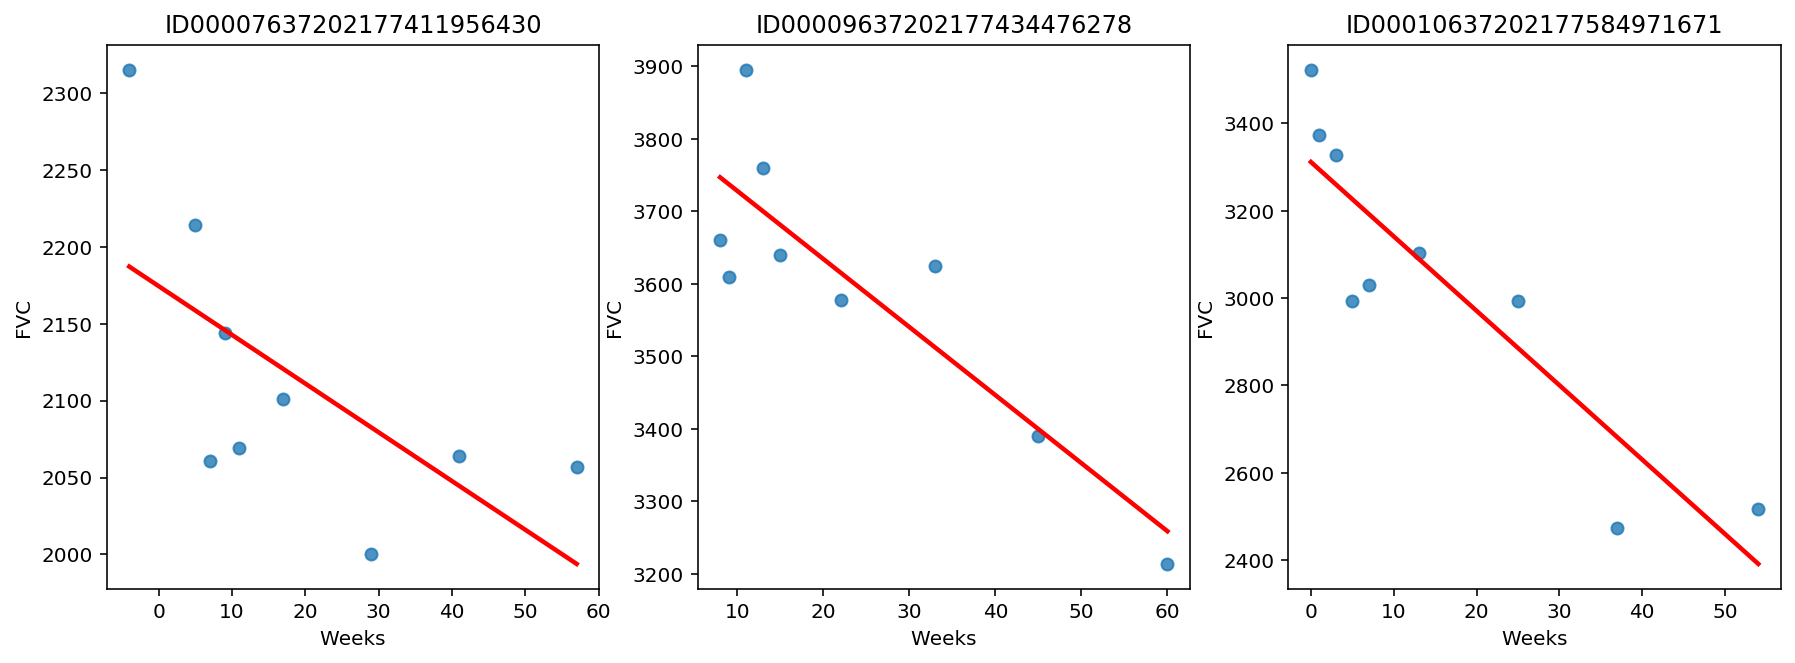

In [18]:
def chart(patient_id, ax):
    data = train[train['Patient'] == patient_id]
    x = data['Weeks']
    y = data['FVC']
    ax.set_title(patient_id)
    ax = sns.regplot(x, y, ax=ax, ci=None, line_kws={'color':'red'})
    

f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart('ID00007637202177411956430', axes[0])
chart('ID00009637202177434476278', axes[1])
chart('ID00010637202177584971671', axes[2])

In [ ]:
"""
m_glmm5 <- ulam(
    alist(
        admit ~ binomial(applications,p),
        logit(p) <- v_mu[1] + v[dept,1] + (v_mu[2] + v[dept,2])*male,
        matrix[dept,2]: v <- t(diag_pre_multiply( sigma , L_Rho ) * z),
        matrix[2,dept]: z ~ normal( 0 , 1 ),
        vector[2]: v_mu[[1]] ~ normal(0,4),
        vector[2]: v_mu[[2]] ~ normal(0,1),
        vector[2]: sigma ~ half_normal(0,1),
        cholesky_factor_corr[2]: L_Rho ~ lkj_corr_cholesky( 2 )
    ),
    data=UCBadmit )
"""

def glmm(dept, male, applications, admit=None):
    v_mu = numpyro.sample('v_mu', dist.Normal(0, jnp.array([4., 1.])))
    sigma = numpyro.sample('sigma', dist.HalfNormal(jnp.ones(2)))
    L_Rho = numpyro.sample('L_Rho', dist.LKJCholesky(2, concentration=2))
    scale_tril = sigma[..., jnp.newaxis] * L_Rho
    # non-centered parameterization
    num_dept = len(np.unique(dept))
    z = numpyro.sample('z', dist.Normal(jnp.zeros((num_dept, 2)), 1))
    v = jnp.dot(scale_tril, z.T).T
    logits = v_mu[0] + v[dept, 0] + (v_mu[1] + v[dept, 1]) * male
    if admit is None:
        # we use a Delta site to record probs for predictive distribution
        probs = expit(logits)
        numpyro.sample('probs', dist.Delta(probs), obs=probs)
    numpyro.sample('admit', dist.Binomial(applications, logits=logits), obs=admit)

In [ ]:
v_mu = numpyro.sample('v_mu', dist.Normal(0, jnp.array([4., 1.])))
sigma = numpyro.sample('sigma', dist.HalfNormal(jnp.ones(2)))
L_Rho = numpyro.sample('L_Rho', dist.LKJCholesky(2, concentration=2))
scale_tril = sigma[..., jnp.newaxis] * L_Rho

# non-centered parameterization
num_dept = len(np.unique(dept))
z = numpyro.sample('z', dist.Normal(jnp.zeros((num_dept, 2)), 1))
v = jnp.dot(scale_tril, z.T).T
logits = v_mu[0] + v[dept, 0] + (v_mu[1] + v[dept, 1]) * male

if admit is None:
    # we use a Delta site to record probs for predictive distribution
    probs = expit(logits)
    numpyro.sample('probs', dist.Delta(probs), obs=probs)
numpyro.sample('admit', dist.Binomial(applications, logits=logits), obs=admit)

In [9]:
# model: one layer
def model(X, Y, D_H):
    D_X, D_Y = X.shape[1], num_classes
    # sample first layer (we put unit normal priors on all weights)
    w1 = numpyro.sample("w1", dist.Normal(jnp.zeros((D_X, D_Y)), jnp.ones((D_X, D_Y))))  # D_X D_H
    z1 = jnp.matmul(X, w1)   # N D_H  <= first layer of activations
    # we put a prior on the observation noise
    prec_obs = numpyro.sample("prec_obs", dist.Normal(0, 1.0))
    sigma_obs = 1.0 / jnp.sqrt(prec_obs)
    # observe data
    numpyro.sample('Y', dist.Multinomial(applications, logits=logits), obs=Y)

def model(PatientID, Weeks, FVC_obs=None):
    μ_α = numpyro.sample("μ_α", dist.Normal(0., 100.))
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(100.))
    μ_β = numpyro.sample("μ_β", dist.Normal(0., 100.))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(100.))
    
    unique_patient_IDs = np.unique(PatientID)
    n_patients = len(unique_patient_IDs)
    
    with numpyro.plate("plate_i", n_patients):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ_β))
    
    σ = numpyro.sample("σ", dist.HalfNormal(100.))
    FVC_est = α[PatientID] + β[PatientID] * Weeks
    
    with numpyro.plate("data", len(PatientID)):
        numpyro.sample("obs", dist.Normal(FVC_est, σ), obs=FVC_obs)

In [10]:
# add patient ID for each patient code:

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['PatientID'] = le.fit_transform(train['Patient'].values)

FVC_obs = train['FVC'].values
Weeks = train['Weeks'].values
PatientID = train['PatientID'].values

In [12]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, PatientID, Weeks, FVC_obs=FVC_obs)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:23<00:00, 171.33it/s, 63 steps of size 1.09e-01. acc. prob=0.88]


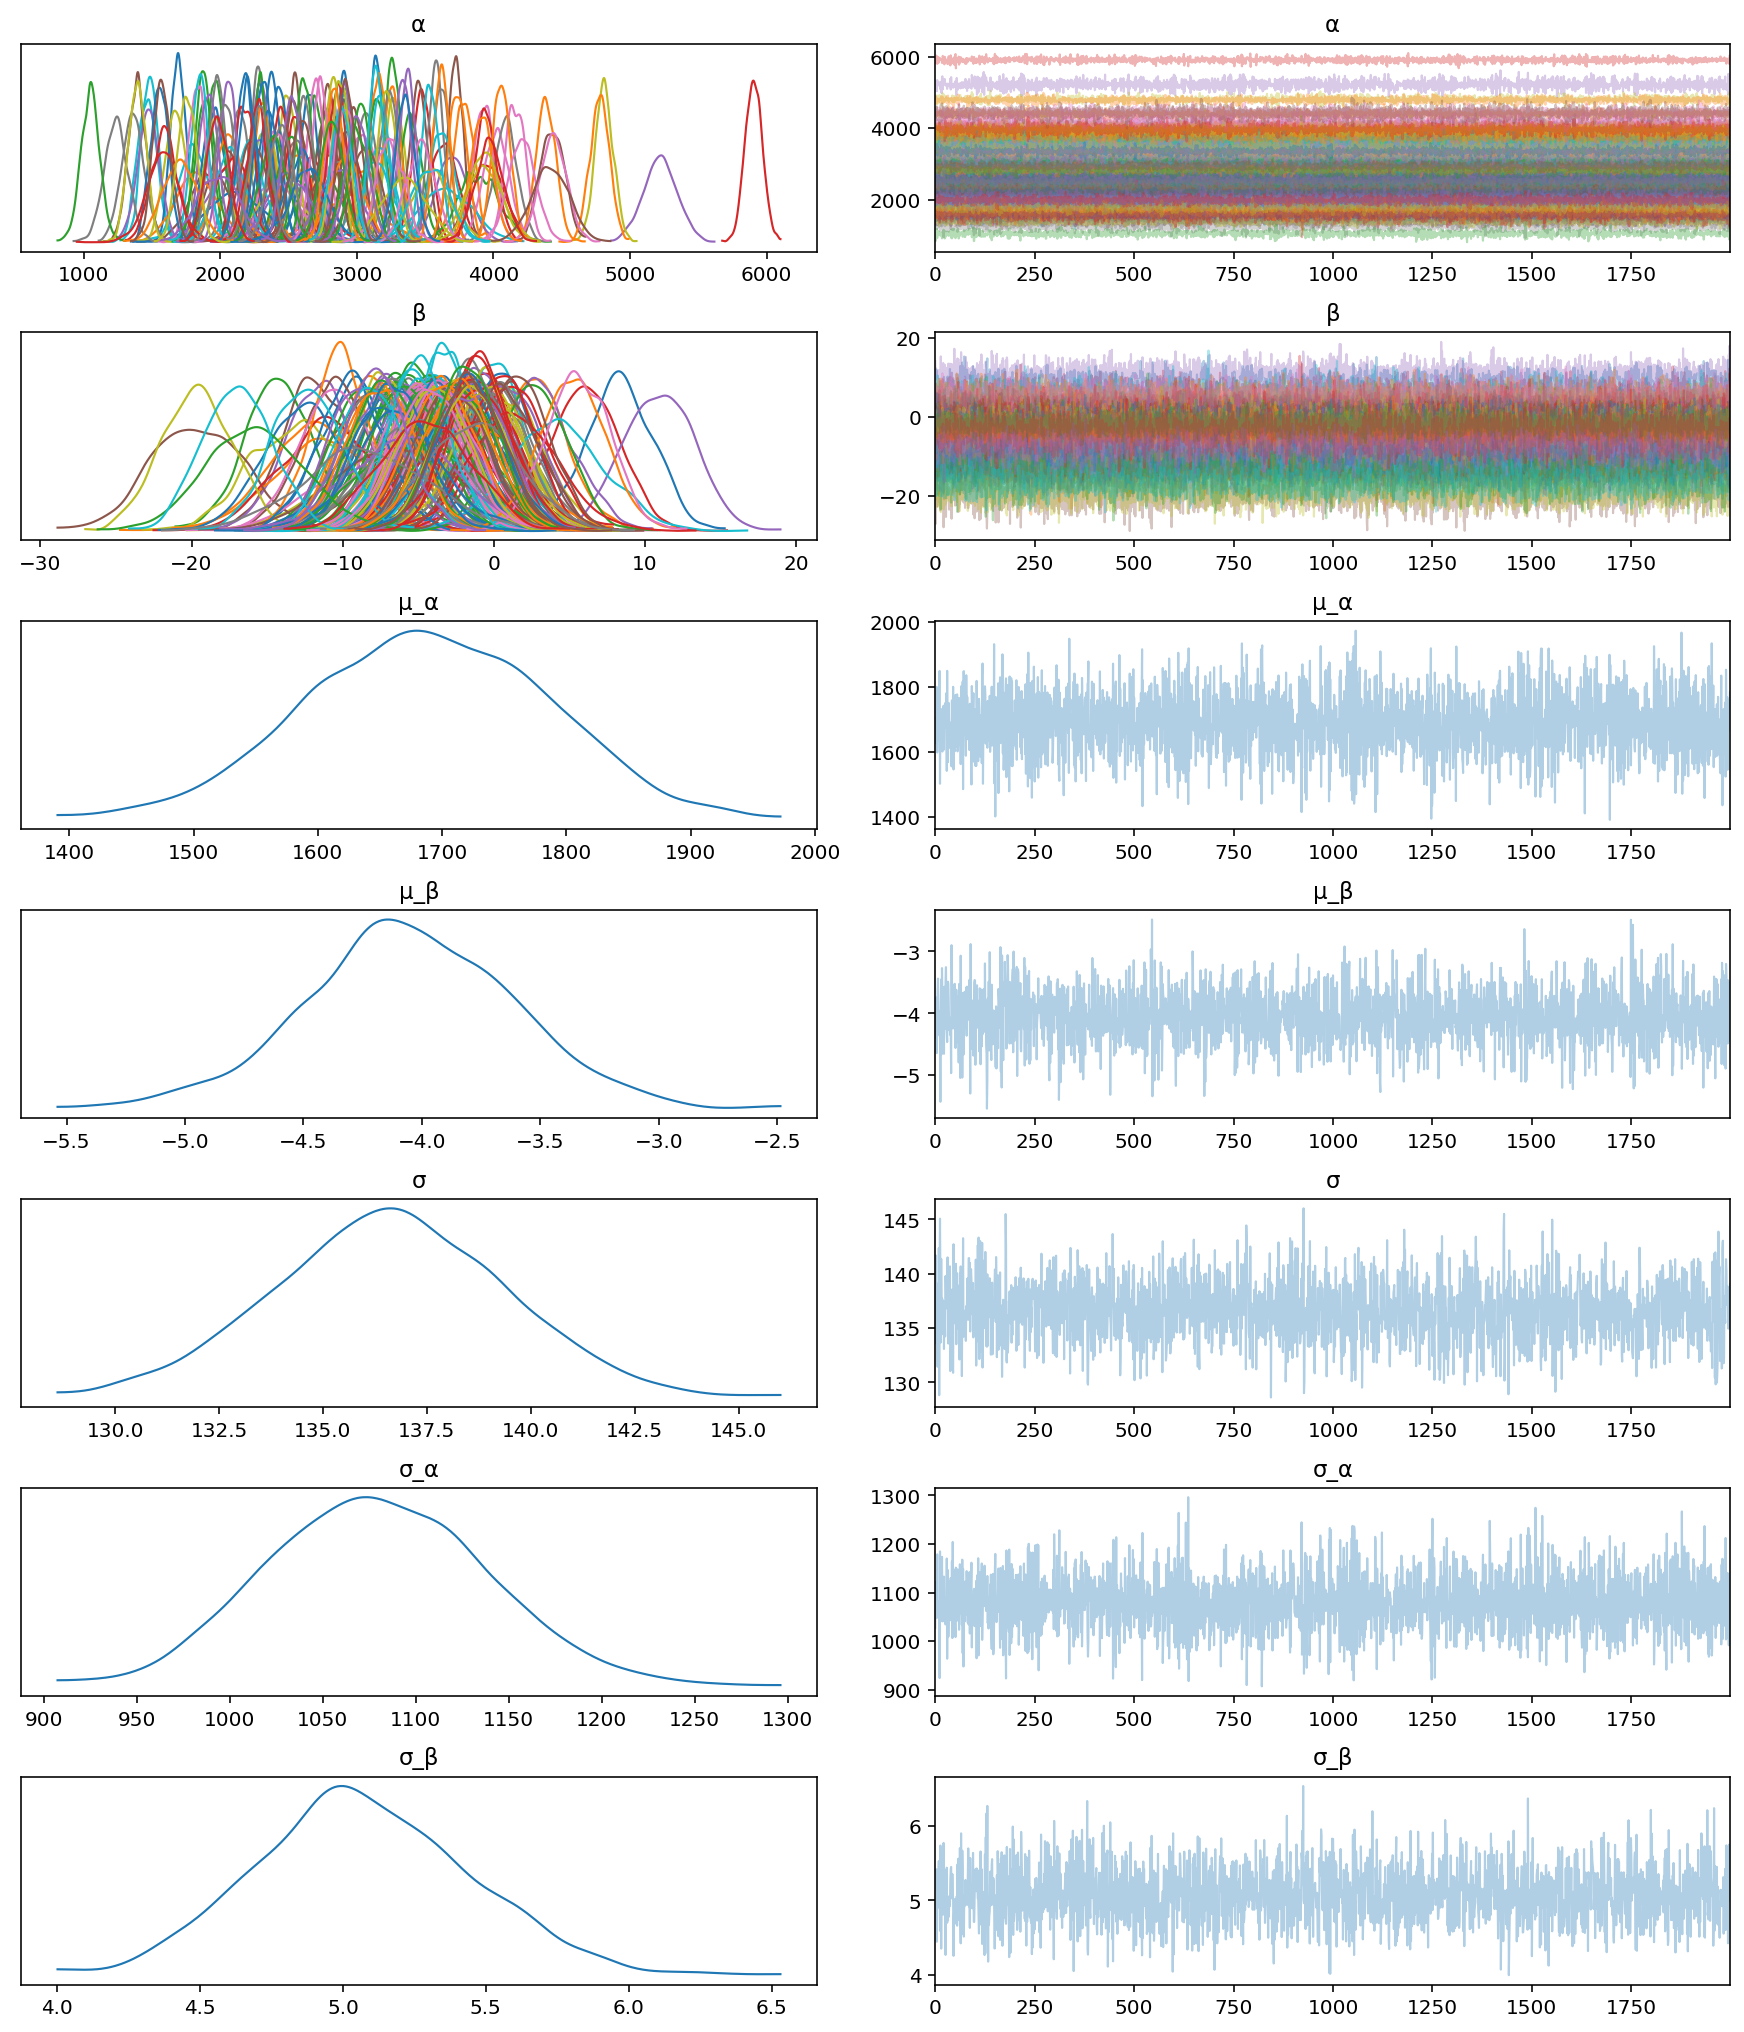

In [14]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

In [16]:
pred_template = []
for i in range(train['Patient'].nunique()):
    df = pd.DataFrame(columns=['PatientID', 'Weeks'])
    df['Weeks'] = np.arange(-12, 134)
    df['PatientID'] = i
    pred_template.append(df)
pred_template = pd.concat(pred_template, ignore_index=True)

In [17]:
PatientID = pred_template['PatientID'].values
Weeks = pred_template['Weeks'].values
predictive = Predictive(model, posterior_samples, 
                        return_sites=['σ', 'obs'])
samples_predictive = predictive(random.PRNGKey(0), 
                                PatientID, Weeks, None)

In [18]:
df = pd.DataFrame(columns=['Patient', 'Weeks', 'FVC_pred', 'sigma'])
df['Patient'] = le.inverse_transform(pred_template['PatientID'])
df['Weeks'] = pred_template['Weeks']
df['FVC_pred'] = samples_predictive['obs'].T.mean(axis=1)
df['sigma'] = samples_predictive['obs'].T.std(axis=1)
df['FVC_inf'] = df['FVC_pred'] - df['sigma']
df['FVC_sup'] = df['FVC_pred'] + df['sigma']
df = pd.merge(df, train[['Patient', 'Weeks', 'FVC']], 
              how='left', on=['Patient', 'Weeks'])
df = df.rename(columns={'FVC': 'FVC_true'})
df.head()

,Patient,Weeks,FVC_pred,sigma,FVC_inf,FVC_sup,FVC_true
0,ID00007637202177411956430,-12,2220.162598,159.290878,2060.871826,2379.453369,NaN
1,ID00007637202177411956430,-11,2210.083496,157.518021,2052.565430,2367.601562,NaN
2,ID00007637202177411956430,-10,2213.199951,154.847916,2058.352051,2368.047852,NaN
3,ID00007637202177411956430,-9,2209.025391,153.300079,2055.725342,2362.325439,NaN
4,ID00007637202177411956430,-8,2203.191895,156.085449,2047.106445,2359.277344,NaN


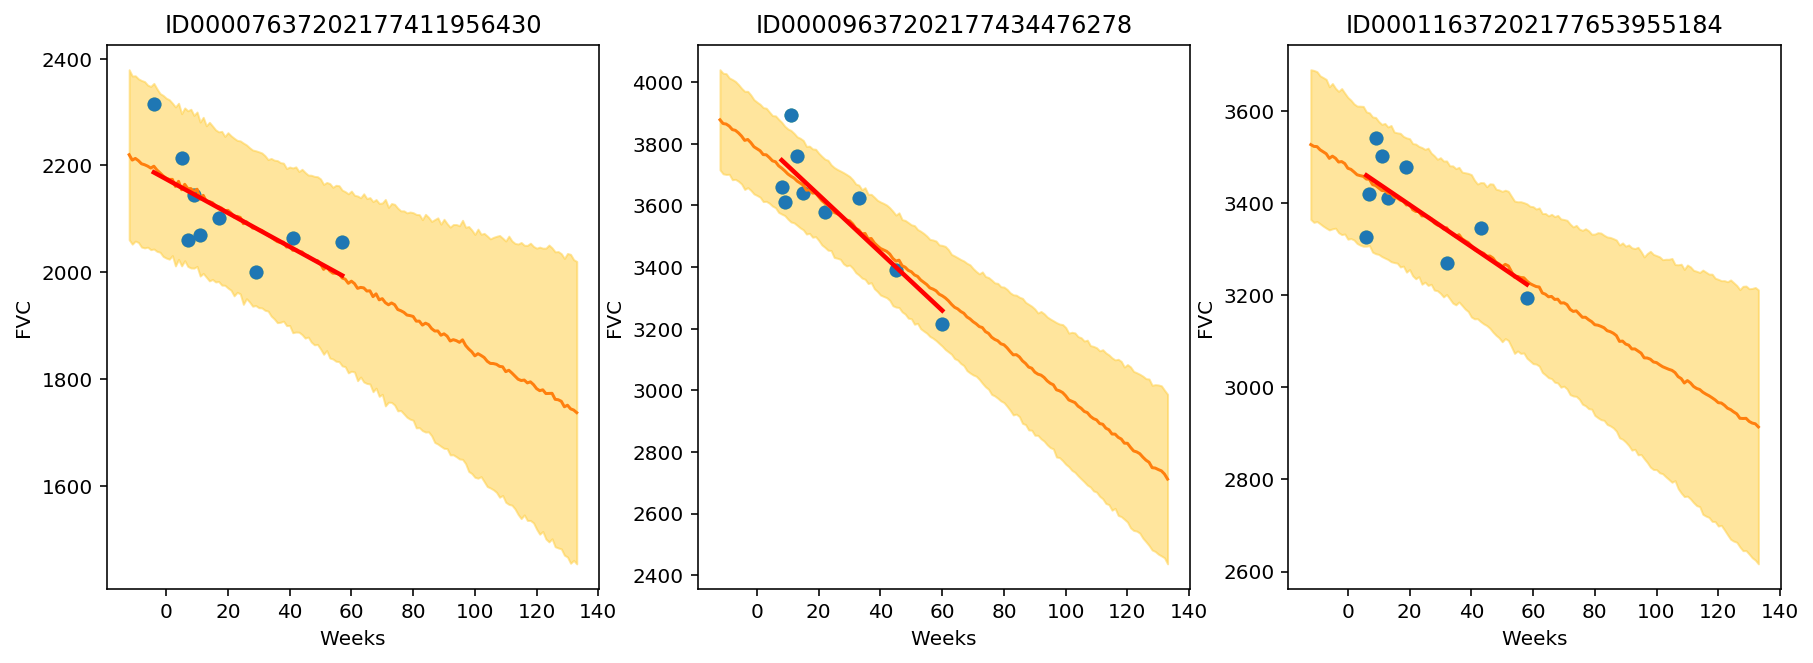

In [19]:
def chart(patient_id, ax):
    data = df[df['Patient'] == patient_id]
    x = data['Weeks']
    ax.set_title(patient_id)
    ax.plot(x, data['FVC_true'], 'o')
    ax.plot(x, data['FVC_pred'])
    ax = sns.regplot(x, data['FVC_true'], ax=ax, ci=None, 
                     line_kws={'color':'red'})
    ax.fill_between(x, data["FVC_inf"], data["FVC_sup"],
                    alpha=0.5, color='#ffcd3c')
    ax.set_ylabel('FVC')

f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart('ID00007637202177411956430', axes[0])
chart('ID00009637202177434476278', axes[1])
chart('ID00011637202177653955184', axes[2])

In [20]:
# laplace log likelihood

y = df.dropna()
rmse = ((y['FVC_pred'] - y['FVC_true']) ** 2).mean() ** (1/2)
print(f'RMSE: {rmse:.1f} ml')

sigma_c = y['sigma'].values
sigma_c[sigma_c < 70] = 70
delta = (y['FVC_pred'] - y['FVC_true']).abs()
delta[delta > 1000] = 1000
lll = - np.sqrt(2) * delta / sigma_c - np.log(np.sqrt(2) * sigma_c)
print(f'Laplace Log Likelihood: {lll.mean():.4f}')

RMSE: 122.1 ml
Laplace Log Likelihood: -6.1375
